### Initial reading function I/Q ###

Total de amostras I/Q complexas lidas: 1000000

Leitura de 40.0 ms (1000000 amostras) concluída com sucesso.


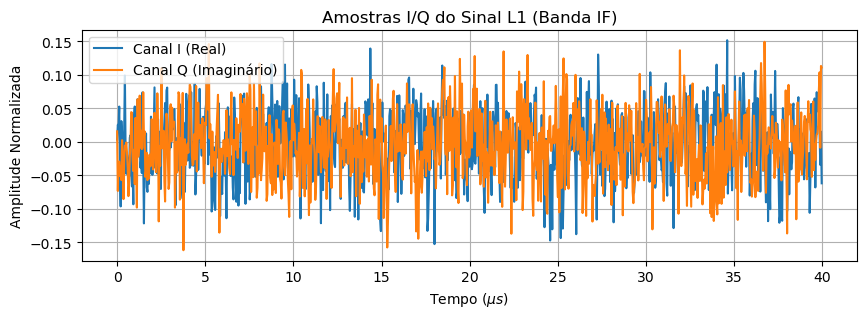

In [8]:
# =================================================================
# 1. IMPORTS E CONFIGURAÇÃO
# =================================================================
import numpy as np
import matplotlib.pyplot as plt
import os
# A biblioteca "math" pode ser útil mais tarde, mas não é estritamente necessária por enquanto.
import math 

# --- Parâmetros do Sinal GPS (TEXBAT) ---
F_s = 25e6        # Taxa de amostragem: 25 MHz (Amostras/segundo)
F_IF = 10e6       # Frequência Intermediária: 10 MHz
data_type = np.int16 # Formato dos dados: Inteiro de 16 bits (signed)

# --- Caminho do Arquivo (Ajuste Necessário) ---
# Se o arquivo ds7.bin estiver na mesma pasta do notebook:
file_path = 'ds7.bin' 

# =================================================================
# 2. FUNÇÃO DE LEITURA OTIMIZADA
# =================================================================
def read_and_process_iq_data(file_path, data_type, num_samples_to_read=None):
    """
    Lê uma quantidade específica de amostras I/Q complexas diretamente do disco.
    A otimização usa o parâmetro 'count' do np.fromfile para evitar
    carregar o arquivo inteiro na memória (solução para o erro de Runtime/OOM).
    """
    
    if num_samples_to_read is None:
        count_raw = -1 # Lê tudo (use com cautela)
    else:
        # Precisamos de 2 inteiros brutos (I e Q) para cada amostra complexa.
        count_raw = int(num_samples_to_read * 2)

    try:
        # Lendo apenas 'count_raw' elementos do arquivo
        raw_data = np.fromfile(file_path, dtype=data_type, count=count_raw)
    except FileNotFoundError:
        print(f"ERRO: Arquivo não encontrado no caminho: {file_path}")
        return np.array([])
    
    if len(raw_data) < 2:
        print("AVISO: Dados lidos insuficientes.")
        return np.array([])

    # Separação e Normalização
    I_samples = raw_data[0::2].astype(np.float32) / 2**15
    Q_samples = raw_data[1::2].astype(np.float32) / 2**15
    
    # Sinal Complexo S(t)
    S_t = I_samples + 1j * Q_samples
    
    print(f"Total de amostras I/Q complexas lidas: {len(S_t)}")
    return S_t

# =================================================================
# 3. EXECUÇÃO
# =================================================================

# 40 milissegundos é o tempo mínimo recomendado para a Aquisição (40 códigos C/A)
NUM_SECONDS_FOR_ACQUISITION = 0.04
F_s = 25e6 # Mantendo a taxa de amostragem

num_samples_to_read = int(NUM_SECONDS_FOR_ACQUISITION * F_s)

# Chama a função otimizada
S_t_snippet = read_and_process_iq_data(
    file_path, 
    data_type, 
    num_samples_to_read=num_samples_to_read
)

if len(S_t_snippet) > 0:
    print(f"\nLeitura de {NUM_SECONDS_FOR_ACQUISITION*1000} ms ({len(S_t_snippet)} amostras) concluída com sucesso.")
# =================================================================
# 4. VERIFICAÇÃO (PLOTS)
# =================================================================
if len(S_t_snippet) > 0:
    num_plot = 1000  # Plotar apenas 1000 amostras para visualização
    time_vector = np.arange(num_plot) / F_s

    plt.figure(figsize=(10, 3))
    plt.plot(time_vector * 1e6, S_t_snippet.real[:num_plot], label='Canal I (Real)')
    plt.plot(time_vector * 1e6, S_t_snippet.imag[:num_plot], label='Canal Q (Imaginário)')
    plt.title('Amostras I/Q do Sinal L1 (Banda IF)')
    plt.xlabel('Tempo ($\mu s$)')
    plt.ylabel('Amplitude Normalizada')
    plt.legend()
    plt.grid(True)
    plt.show()

#

### Testing if the reading function worked as planned ###


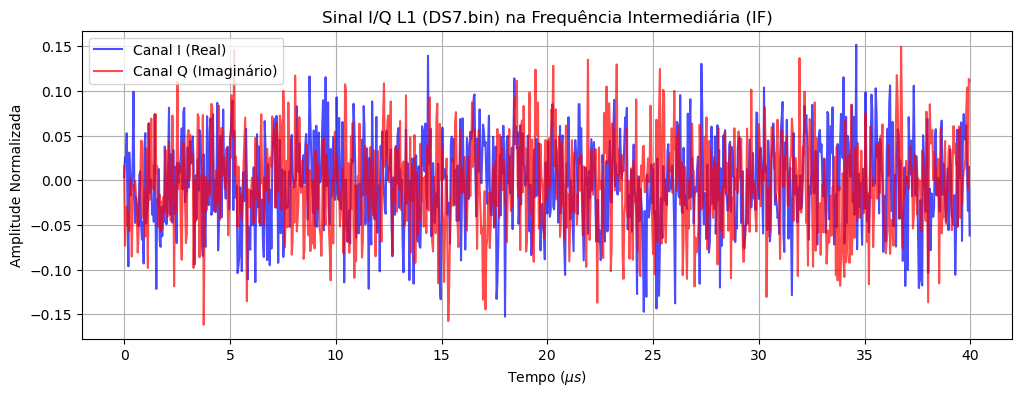

In [11]:
if len(S_t_snippet) > 0:
    # --- Parâmetros de Plotagem ---
    F_s = 25e6
    num_plot = 1000  # Quantidade de amostras para visualizar
    
    # 1. Crie o vetor de tempo
    # Usamos np.arange para criar um vetor de tempo em microssegundos (μs) para melhor visualização.
    time_vector_us = np.arange(num_plot) / F_s * 1e6

    # 2. Plotar
    plt.figure(figsize=(12, 4))
    
    # Plota o Canal I (Parte Real do sinal complexo)
    plt.plot(time_vector_us, S_t_snippet.real[:num_plot], 
             label='Canal I (Real)', 
             color='blue', 
             alpha=0.7)
             
    # Plota o Canal Q (Parte Imaginária do sinal complexo)
    plt.plot(time_vector_us, S_t_snippet.imag[:num_plot], 
             label='Canal Q (Imaginário)', 
             color='red', 
             alpha=0.7)
             
    plt.title('Sinal I/Q L1 (DS7.bin) na Frequência Intermediária (IF)')
    plt.xlabel('Tempo ($\mu s$)') # μs é microssegundo
    plt.ylabel('Amplitude Normalizada')
    plt.legend()
    plt.grid(True)
    plt.show()

#

### Downconversion ###

Deslocar a frequência de um sinal de uma Frequência Intermediária (IF) mais alta para uma frequência próxima de zero hertz (Banda Base).

No TEXBAT o sinal GPS L1 foi capturado e convertido para uma frequência intermediária de 10MHz, esse downconversio é realizado para 
fazer o shift do sinal para a Banda Base. 

Fazemos o downconversion para podermos gerar um pico de correlação claro e detectável, já que com uma frequências muito altas a amplitude é cancelada, pois a soma de uma senoidal ao longo de mutiplos ciclos é 0.

[ 0.00344849+0.01580811j  0.0256958 -0.07321167j  0.02230835-0.03091431j
 ... -0.07058716-0.08221436j -0.043396  -0.05255127j
 -0.0534668 -0.19006348j]


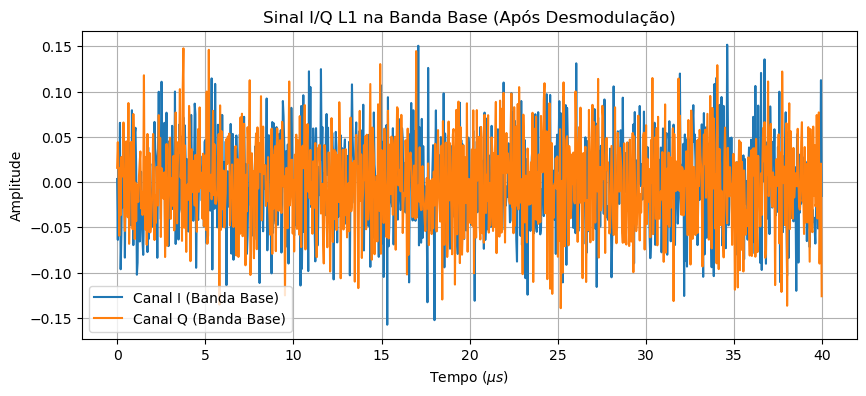

In [ ]:
# CÉLULA 3: DOWNCONVERSION (Fase 2.2 - Etapa 1)

# Parâmetros
F_s = 25e6
F_IF = 10e6
S_t = S_t_snippet # Usamos o trecho de 1 ms

# 1. Crie o vetor de tempo
# np.arange cria um vetor de tempo, onde o último elemento não é incluído, por isso len(S_t)
t = np.arange(len(S_t)) / F_s

# 2. Crie a portadora local complexa (exponencial complexa)
# Sinais e Sistemas: Multiplicação por e^(-j * 2 * pi * F_IF * t)
local_carrier = np.exp(-1j * 2 * np.pi * F_IF * t)

# 3. Desmodulação (Downconversion)
S_bb = S_t * local_carrier

# Verificação: O sinal S_bb deve ter amplitude máxima em 0 Hz (Banda Base)
plt.figure(figsize=(10, 4))
plt.plot(t[:1000] * 1e6, S_bb.real[:1000], label='Canal I (Banda Base)')
plt.plot(t[:1000] * 1e6, S_bb.imag[:1000], label='Canal Q (Banda Base)')
plt.title('Sinal I/Q L1 na Banda Base (Após Desmodulação)')
plt.xlabel('Tempo ($\mu s$)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#